In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

## Design Idea

In [2]:
span = 2540
offset = -25
slice_heigth = 161

(2857, 3058, 3)


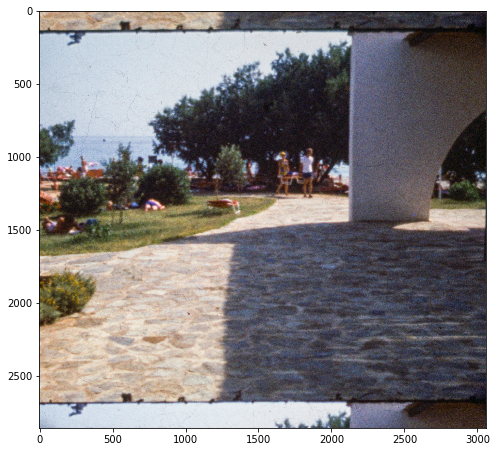

In [3]:
imgpath = "/Users/jankaiser/Desktop/stab_test/frame-00702.jpg"
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.figure(figsize=(8,8))
plt.imshow(img, interpolation="none")
plt.show()

In [4]:
def extract_sample(frame, span=2540, offset=-25, slice_heigth=161):
    bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    normed = bw / 255
    
    middle = normed.shape[0] / 2
    upper = middle + offset - span / 2
    lower = middle + offset + span / 2

    upper_slice = normed[int(upper-slice_heigth/2):int(upper+slice_heigth/2),:]
    lower_slice = normed[int(lower-slice_heigth/2):int(lower+slice_heigth/2),:]

    upper_squashed = cv2.resize(upper_slice, (161,161))
    lower_squashed = cv2.resize(lower_slice, (161,161))

    sample = np.stack([upper_squashed,lower_squashed])
    return sample

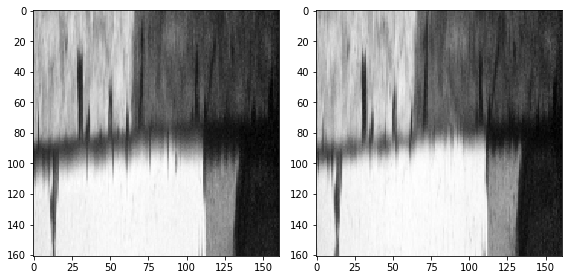

In [5]:
sample = extract_sample(img, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sample[0], cmap="gray", interpolation="none")
plt.subplot(122)
plt.imshow(sample[1], cmap="gray", interpolation="none")
plt.tight_layout()
plt.show()

## Create Training Data

(1335, 2000, 3)


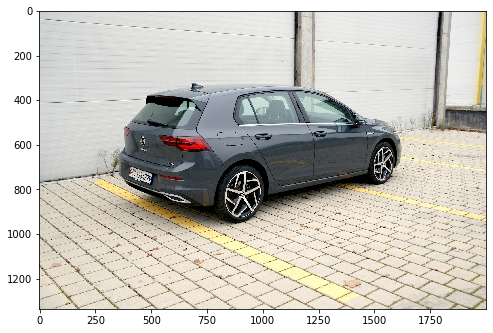

In [18]:
train_img = cv2.imread("/Users/jankaiser/Downloads/@Test-VW-Golf-8-4.jpeg", cv2.IMREAD_COLOR)
# train_img = cv2.imread("/Users/jankaiser/Downloads/19321040610_920395f4aa_o.jpg", cv2.IMREAD_COLOR)
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

print(train_img.shape)

plt.figure(figsize=(8,8))
plt.imshow(train_img, interpolation="none")
plt.show()

In [19]:
def resize_to_fill(img, new_size):
    old_ar = img.shape[1] / img.shape[0]
    new_ar = new_size[1] / new_size[0]

    if old_ar > new_ar:
        crop_width = int(img.shape[0] * new_ar)
        cutoff = int((img.shape[1] - crop_width) / 2)
        cropped = img[:,cutoff:-cutoff]
    else:
        crop_height = int(img.shape[1] / new_ar)
        cutoff = int((img.shape[0] - crop_height) / 2)
        cropped = img[cutoff:-cutoff,:]
        
    resized = cv2.resize(cropped, (new_size[1],new_size[0]))
    return resized

(2540, 3058, 3)


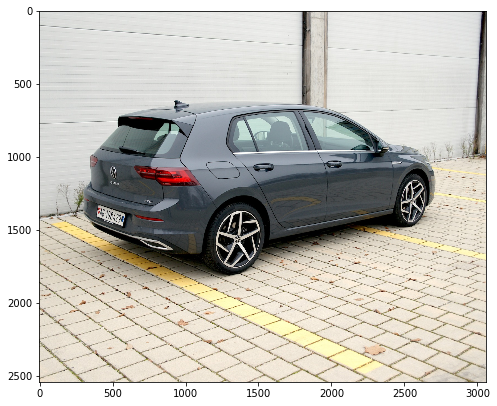

In [20]:
resized = resize_to_fill(train_img, (span,img.shape[1]))
print(resized.shape)

plt.figure(figsize=(8,8))
plt.imshow(resized, interpolation="none")
plt.show()

In [21]:
def draw_frame(img, sample_shape, offset, du, dl):
    ypos = int((sample_shape[0] - img.shape[0]) / 2 + offset)

    sample = np.zeros(sample_shape, dtype="uint8")
    sample[ypos:ypos+img.shape[0]] = img

    uypos = ypos - img.shape[0] - du
    uheight = uypos + img.shape[0]
    sample[0:uheight] = img[-uheight:]

    lypos = ypos + img.shape[0] + dl
    lheight = sample.shape[0] - lypos
    sample[-lheight:] = img[:lheight]

    return sample

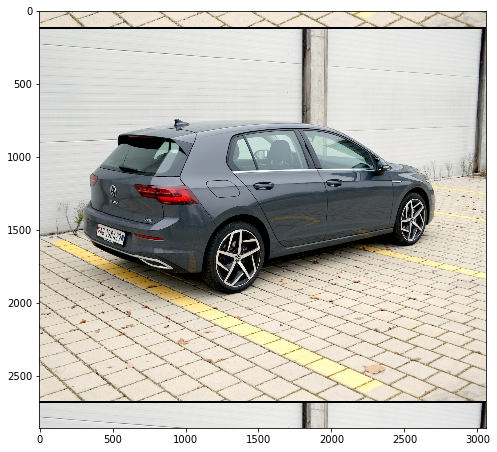

In [22]:
frame = draw_frame(resized, img.shape, offset, 20, 10)

plt.figure(figsize=(8,8))
plt.imshow(frame, interpolation="none")
plt.show()

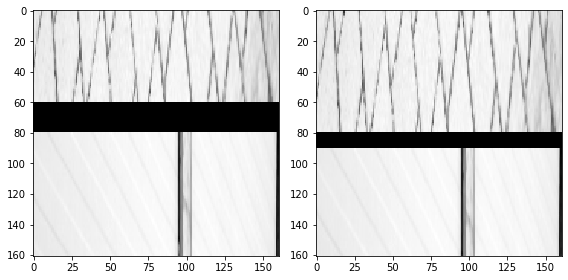

In [23]:
sample = extract_sample(frame, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sample[0], cmap="gray", interpolation="none")
plt.subplot(122)
plt.imshow(sample[1], cmap="gray", interpolation="none")
plt.tight_layout()
plt.show()

## Train

In [19]:
model = keras.Sequential([
    Conv2D(16, (5,25), strides=(1,7), activation="relu", input_shape=(161,161,2)),
    Conv2D(8, (3,15), strides=(1,1), activation="relu"),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1)
])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 157, 20, 16)       4016      
                                                                 
 conv2d_35 (Conv2D)          (None, 155, 6, 8)         5768      
                                                                 
 flatten_17 (Flatten)        (None, 7440)              0         
                                                                 
 dense_34 (Dense)            (None, 32)                238112    
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 247,929
Trainable params: 247,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

## Generate Stabilised Video